# Neural Networks for Data Science Applications
## Homework 1: Saliency maps for interpretability

**Name**: *Federico Alvetreti*

**Matricola**: *1846936*

> ✍ Upload the completed notebook **before 10/11/2023 at 23:59** on the Google Classroom page.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Normalization
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NN


### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**), and a few optional exercises. Optional exercises are provided if you like the topic and would like to explore more; you are free to ignore them or complete as many as you want. I will not grade them but I might provide feedback for especially nice solutions.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. If your grade does not satisfy you, you are also free to complete the full EoT homework to recover it.
3. The grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

### Warmup: Data loading

For this homework, you can select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**Answer**

I choose to work with one of the most known datasets: the **CIFAR10**.


CIFAR10 consists a total of 6000 images with shape 32x32x3.

Each image is labeled into one of this classes:

Airplane, Automobile, Bird, Cat, Deer, Dog , Frog, Horse, Ship or Truck.


The reasons behind this choice are the following:

- Always heard of this dataset, never worked with it.
- I wanted to work with images and Convolutional Neural Networks.
- It is easily obtainable with the "tensorflow_datasets" package, which implies I will not waste too much time for preprocessing.
- It's well known but not too easy. It still has 10 classes and  32x32x3 images often make even humans struggle with classification.
- This homework isn't about the dataset.




In [ ]:
# Here I load the CIFAR10 dataset and partition it into train, test and validation.

# It may appear unconventional to manually handle the train/val/test split, since the tfds package inherently provides this functionality.
# However, during experimentation, I encountered unexpected anomalies in training when utilizing the default tfds split.
# Specifically, the training process exhibited unusual behavior where the val_loss was consistently under train_loss, even in the absence of any dropout layers.
# This trend persisted across various train/val splits, including extreme cases, such as allocating only one element to the train set and the remainder to the val set.
# To address this issue, I opted to concatenate the entire CIFAR10 dataset into a single data variable and subsequently perform the division into train/val/test manually.
# This adjustment seems to mitigate the observed anomalous behavior.


# Load cifar10 from the tensorflow_datasets package
data_train = tfds.load("cifar10", split="train", try_gcs = True)
data_test = tfds.load("cifar10", split="test", try_gcs = True)

# Concatenate train and test
data = data_train.concatenate(data_test)

# Set validation and test percentages
validation_percentage = 0.2
test_percentage = 0.1

# Get validation size and test size
validation_size = int(validation_percentage * len(data))
test_size = int(test_percentage * len(data))

# Split into train, validation and test
train = data.skip(validation_size + test_size)
test = data.skip(validation_size).take(test_size)
validation = data.take(validation_size)

# Print length of each dataset type
print("Train samples:", len(train))
print("Validation samples:", len(validation))
print("Test samples:", len(test))

Train samples: 42000
Validation samples: 12000
Test samples: 6000


In [ ]:
# Let's immediatelly create the "preprocessed" versions of our datasets.
# I will work with "BatchDataset" objects, to optimize training.
# The preprocessing consists of:
#     - formatting the image into [0,1]
#     - dividing each element into a tuple of "image" and "label"
#     - dividing the dataset into batches.
# These preprocessed datasets are the one I will use for training, validating and testing.


# Setting the number of batches
n_batch = 200

# Our preprocessing function
def preprocess_data(item):
  image = tf.cast(item['image'], tf.float32) / 255.0
  label = item['label']
  return image, label

# Apply preprocessing and divide into batches
train_preprocessed = train.map(preprocess_data).batch(n_batch)
val_preprocessed = validation.map(preprocess_data).batch(n_batch)
test_preprocessed = test.map(preprocess_data).batch(n_batch)

In [ ]:
# In this last manipulation of the datasets  we create a compact 4D tensor for
# the test images and an associated tensor of labels.
# It will be usefull mainly for plot related codes and for computing Saliency Maps.

# Extract the images from the  batch
images_batches = [batch[0] for batch in test_preprocessed]

# Extract the labels from the batch
labels_batches = [batch[1] for batch in test_preprocessed]

# Merge all the images batches into a single batch
test_images_tensor = tf.concat(images_batches, axis=0)

# Merge all the labels batches into a single batch
test_labels_tensor = tf.concat(labels_batches, axis=0)



# Extract the images from the  batch
images_batches = [batch[0] for batch in train_preprocessed]

# Extract the labels from the batch
labels_batches = [batch[1] for batch in train_preprocessed]


# Merge all the images batches into a single batch
train_images_tensor = tf.concat(images_batches, axis=0)

# Merge all the labels batches into a single batch
train_labels_tensor = tf.concat(labels_batches, axis=0)


Let's end this section by plotting a sample of images from the CIFAR10 dataset:

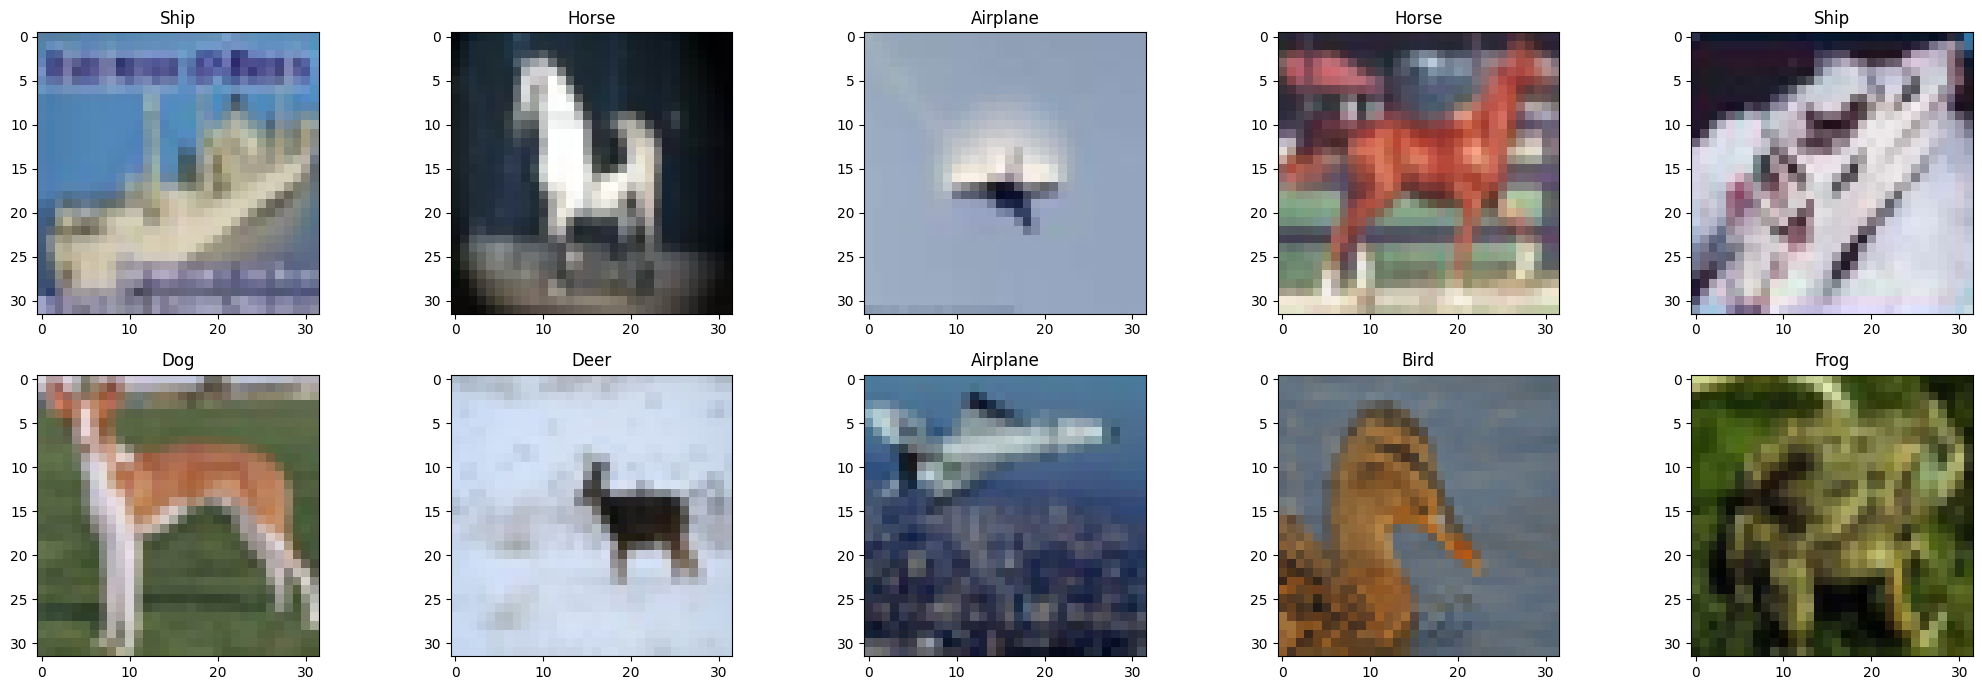

In [ ]:
# Let's visualize the first elements of our dataset.
# I will use the following function, which will be used trouhgout the whole notebook.
# It is simply a custom plotting of images contained in an array or tensor:

def plot_images(images_vec, labels, nrow, ncols, preprocess_func = None, fig_size = (21,7)):
  # Apply preprocessing if passed
  if preprocess_func is not None:
    images_vec = [preprocess_func(image) for image in images_vec]

  # Fix fig_size and number of subplots
  fig, axes = plt.subplots(nrow, ncols, figsize = fig_size)

  # Plot each image and its label in a subplot
  for i in range(nrow * ncols):
    ax = axes[i // ncols, i % ncols]
    ax.imshow(images_vec[i])
    ax.set_title(f"{labels[i]}")

  plt.tight_layout()
  plt.show()


# This are the labels of our dataset
labels_names = ["Airplane", "Automobile", "Bird", "Cat","Deer","Dog","Frog","Horse","Ship","Truck"]

# Get first 8 images and its labels
images = test_images_tensor[:10]
labels = [labels_names[test_labels_tensor[i]] for i in range(10)]

# Plot them
plot_images(images, labels, 2, 5)

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function, normalization layers, etc.), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Additional comments and visualizations are also appreciated.

As I already anticipated I wanted to create a Convolutional Neural Network.

I tried many combinations and this is what I noticed:
- If the model trained very fast it would reach overfitting the same way.
- Light CNN behaved poorly.
- Dropout increased both training time and accuracy.


After many attempts what seemed to perform best was an **heavy and slow CNN with a lot of dropout**

In [ ]:
# Hyperparameters

# High number of epochs
num_epochs = 100

# High Dropout prob
dropout_prob = 0.5

# Optimizer setup
lr = 0.0001
my_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [ ]:
# Here its defined the CNN.

# As any good NN hat a normalization layer on top.
# Then we have 6 Convolutional layers that transform the input from 32x32x3 -> 1x1x1600
# Finally we have 2 Dense layers that end the network.
# Note that I didn't provide a Softmax layer since it is already handled by the loss function.

CNN = Sequential()

# Normalization layer

CNN.add(Normalization())

# Convolutional layers

# 32 x 32 x 3
CNN.add(Conv2D(filters = 20, kernel_size = 3, activation = "relu"))
CNN.add(Dropout(rate = dropout_prob))
# 30 x 30 x 20

# 30 x 30 x 20
CNN.add(Conv2D(filters = 100, kernel_size = 3, activation = "relu", strides = (2,2)))
CNN.add(Dropout(rate = dropout_prob))
# 14 x 14 x 100

# 14 x 14 x 100
CNN.add(Conv2D(filters = 200, kernel_size = 2, activation = "relu", strides = (2,2)))
CNN.add(Dropout(rate = dropout_prob))
# 7 x 7 x 200

# 7 x 7 x 200
CNN.add(Conv2D(filters = 400, kernel_size = 3, activation = "relu"))
CNN.add(Dropout(rate = dropout_prob))
# 5 x 5 x 400

# 5 x 5 x 400
CNN.add(Conv2D(filters = 800, kernel_size = 3, activation = "relu", strides = (2,2)))
CNN.add(Dropout(rate = dropout_prob))
# 2 x 2 x 800

# 2 x 2 x 800
CNN.add(Conv2D(filters = 1600, kernel_size = 2, activation = "relu"))
CNN.add(Dropout(rate = dropout_prob))
# 1 x 1 x 1600


# Flatten the 3D output to 1D for the fully connected layers

# 1 x 1 x 1600
CNN.add(Flatten())
# 1600

# Dense Linear Layers

# 1600
CNN.add(Dense(units = 500, input_dim = 1600, activation = "relu")) # 1x100
CNN.add(Dropout(rate = dropout_prob, input_shape=(1,1,100)))
# 500

# 500
CNN.add(Dense(units = 10, input_dim = 500, activation = "relu")) # 1x10
# 10

In [ ]:
# CNN building and summary
CNN.build(input_shape=(None, 32, 32, 3))
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 32, 32, 3)         7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 20)        560       
                                                                 
 dropout (Dropout)           (None, 30, 30, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 100)       18100     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 100)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 200)         80200     
                                                        

In [ ]:
# Here we compile the CNN: we choose the SparseCategoricalCrossentropy as loss function and the accuracy as metrics.
# Also here we add a checkpoint saver, that saves the weights every 10 epochs (2100 batches).

# Compile the CNN
CNN.compile(optimizer = my_optimizer, loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

# Save the best weights based on validation loss (its already set up to save your best weights in case you want to retrain CNN)
model_checkpoint_callback = ModelCheckpoint(
    filepath ='models_weights/your_best_weights_CNN.h5',
    save_weights_only = True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)

**Run this cell if you want to retrain the model**

In [ ]:
# Train the CNN
CNN_history = CNN.fit(
    x = train_preprocessed,
    epochs = num_epochs,
    validation_data = val_preprocessed,
    batch_size = n_batch,
    callbacks= model_checkpoint_callback )

# Save history
CNN_history = CNN_history.history

# Load best model weights
CNN.load_weights('models_weights/your_best_weights_CNN.h5')

**Run this cell if you want to load my training history and weights**

In [ ]:
# Load training history
with open('train_histories/CNN_history.json', 'r') as fp:
    CNN_history = json.load(fp)

CNN.load_weights('models_weights/my_best_weights_CNN.h5')


**Accuracy and loss plots**

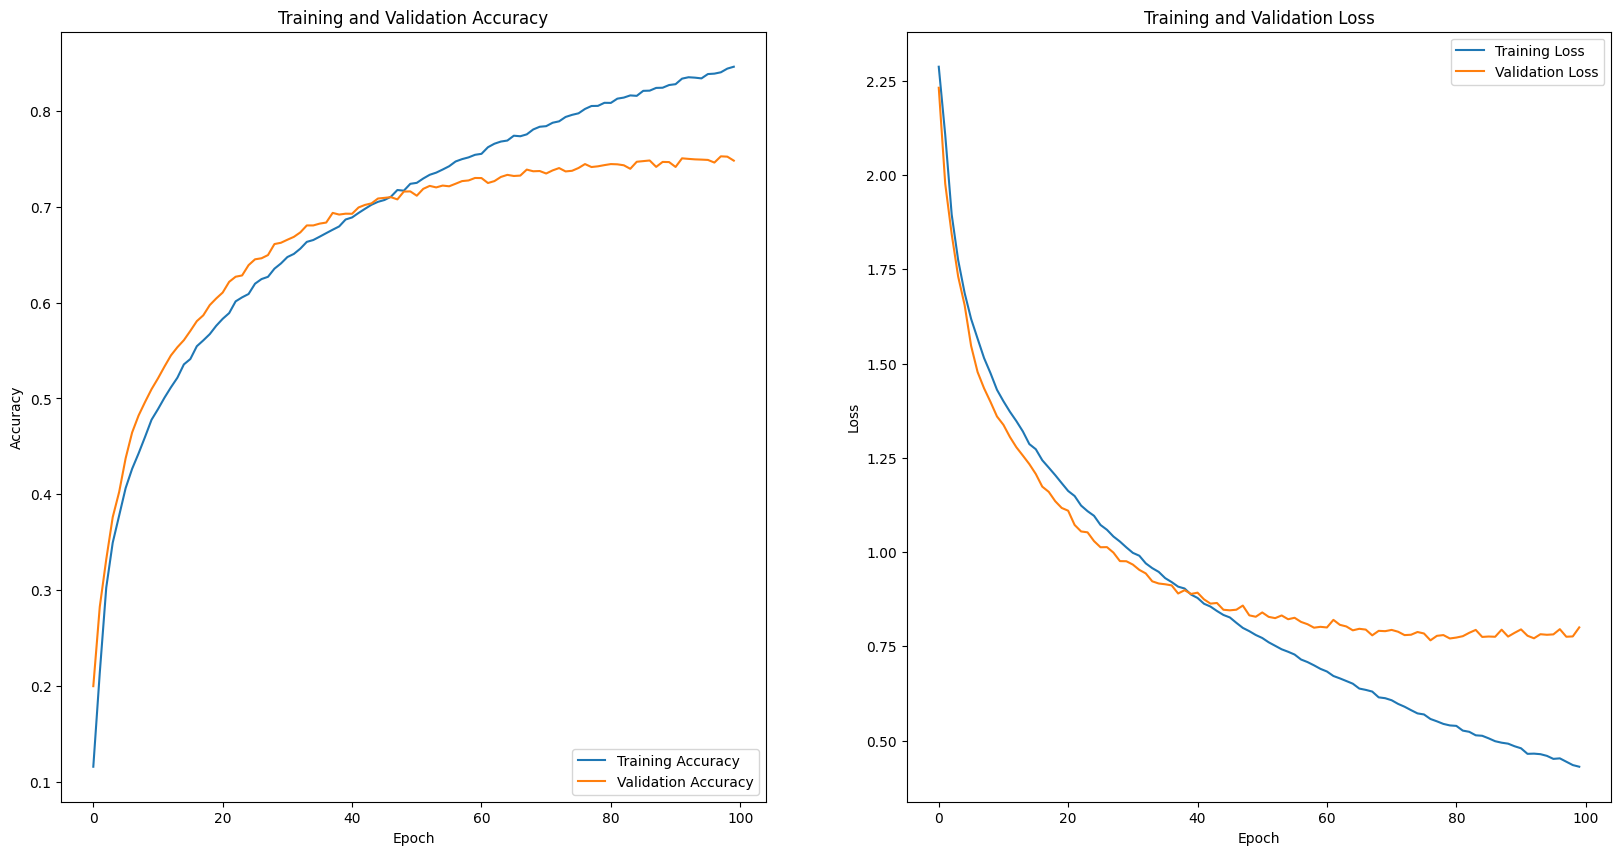

In [ ]:
# Store accuracies
acc = CNN_history['accuracy']
val_acc = CNN_history['val_accuracy']

# Store losses
loss = CNN_history['loss']
val_loss = CNN_history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot accuracies
ax = axes[0]
ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

# Plot losses
ax = axes[1]
ax.plot( loss, label='Training Loss')
ax.plot( val_loss, label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
plt.show()

**Evaluation on test**

In [ ]:
# Evaluate the best model on test set
CNN.evaluate(test_preprocessed)

30/30 [==============================] - 0s 13ms/step - loss: 0.7621 - accuracy: 0.7500


[0.7620664834976196, 0.75]

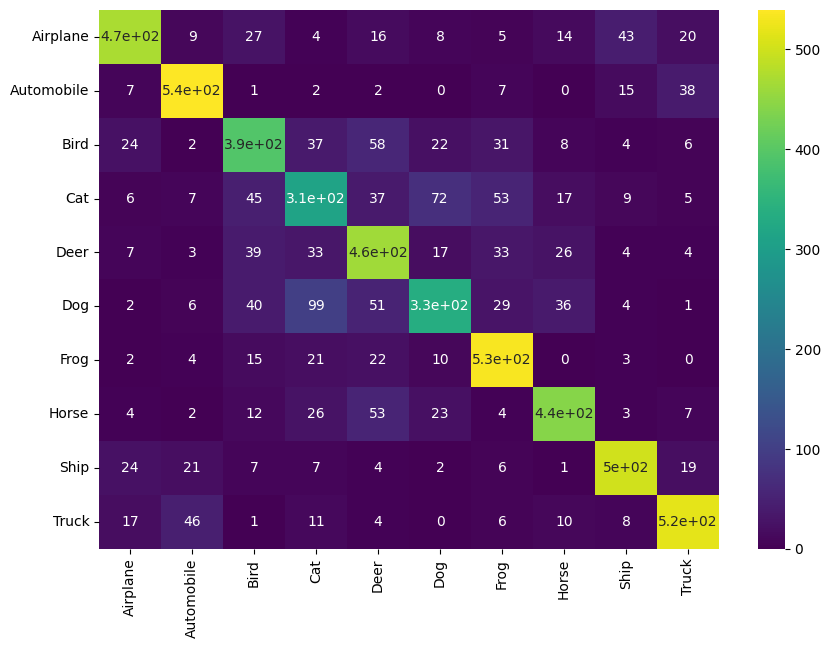

In [ ]:
# Create confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels = test_labels_tensor, predictions = tf.argmax(CNN(test_images_tensor),1))

# Plot confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(pd.DataFrame(confusion_matrix, index = labels_names, columns = labels_names), annot = True, cmap = "viridis")
plt.show()

### Exercise 2: Computing a vanilla saliency map (1 points)

> Before starting, I suggest you read [1] as a warm-up. This is one of the first papers that tried to apply this kind of techniques to modern neural networks.

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

✅ **Completion requirement**: Take any point from your test dataset, and compute a saliency map using `tf.GradientTape`. Check the weight to see if you can find anything to "interpret". **Note**: I am not evaluating how nice / good the explanation is, only the code.

**Answer**

I will provide here three functions:

- `get_saliency_map` which takes a model and an input image and return its saliency map;
- `plot_saliency_preprocessing` which applies the preprocessing suggested in [2];
- `plot_saliency_map` which provides a custom plot of the saliency map.


In [ ]:
# This function computes the saliency map given a model and a single input (image in our case).
# It's been built to both take as input 32x32x3 or 1x32x32x3 shapes.

def get_saliency_map(model, input_image):

  # Reshape into a suitable shape for the model
  input_image = tf.reshape(input_image, (1, 32, 32, 3))


  with tf.GradientTape() as tape:
        # Keep an eye on the input_image evolution
        tape.watch(input_image)

        # Get the prediction of our model
        result = model(input_image, training = False)
        pred = tf.math.reduce_max(result, axis = 1)

        # Derive pred with respect to the input_image
        saliency_map = tape.gradient(pred, input_image)

        # Take the absolute values
        saliency_map = tf.abs(saliency_map)

  return saliency_map


# This function applies the preprocessing suggested in [2] before plotting a saliency map:
#    - it caps outliers to the 99th percentile;
#    - it scales the map into [0,1] with min/max scaling.

def plot_saliency_preprocessing(saliency_map, percentile = 99):

  initial_shape = saliency_map.shape

  # Cap the values to a certain percentile
  flattened_tensor = tf.reshape(saliency_map, [-1])
  quantile = tfp.stats.percentile(flattened_tensor, percentile)
  capped_tensor = tf.where(saliency_map > quantile, quantile, saliency_map)
  saliency_map = tf.reshape(capped_tensor, initial_shape)

  # Min-Max scaling
  min = tf.reduce_min(saliency_map)
  max = tf.reduce_max(saliency_map)
  saliency_map = (saliency_map - min) / (max - min)

  return saliency_map

# This function, as the name suggests, is just a custom plot for saliency maps.
# It plots:
#    - the original image;
#    - the raw saliency map (matching the input image shape);
#    - the single (1D) saliency map, obatined by maxing over the channels (as suggested in [1]);
#    - the overlay of the 1D saliency map and the original image.
#
# I decided to keep the raw saliency map since it may provide informations about the importance of colors.

def plot_saliency_map(saliency_map, input_image = None, label = None, pred = None, percentile = 99):

  # Handle the case of 1x32x32x3 saliency map shape
  saliency_map = tf.reshape(saliency_map, (32, 32, 3))

  # Apply preprocessing
  saliency_map = plot_saliency_preprocessing(saliency_map, percentile)

  # Create 1D saliency map doing the max over channels
  flat_saliency_map = tf.reduce_max(saliency_map,2)

  # If no input image is provided just plot the saliency map
  if input_image is None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))

    # Plot the raw saliency map
    ax = axes[0]
    ax.set_title("Raw Saliency Map")
    ax.imshow(saliency_map)

    # Plot 1D saliency map
    ax = axes[1]
    ax.set_title("Single Saliency Map")
    ax.imshow(flat_saliency_map)


  else:

    # Handle the case of 1x32x32x3 input image shape
    input_image = tf.reshape(input_image, (32, 32, 3))

    fig, axes = plt.subplots(1, 4, figsize=(15, 15))

    # Plot the original image
    ax = axes[0]
    ax.set_title(f"Original Image")
    ax.imshow(input_image)

    # Plot raw saliency map
    ax = axes[1]
    ax.set_title("Raw Saliency Map")
    ax.imshow(saliency_map)

    # Plot 1D saliency map
    ax = axes[2]
    ax.set_title("Single Saliency Map")
    ax.imshow(flat_saliency_map)

    # Plot overlay
    ax = axes[3]
    ax.set_title("Overlay")

    # Plot the original image

    # Overlay the 1d saliency map with reduced alpha to visualize it on top of the original image
    ax.imshow(flat_saliency_map)
    ax.imshow(input_image,alpha = 0.7)

    plt.tight_layout()
    plt.show()
    if(label is not  None and pred is not None):
      print(f"Image label: {label}\nModel prediction: {pred}")

In [ ]:
# Get test predictions as  a tensor
test_predictions_tensor = tf.argmax(CNN(test_images_tensor),1)

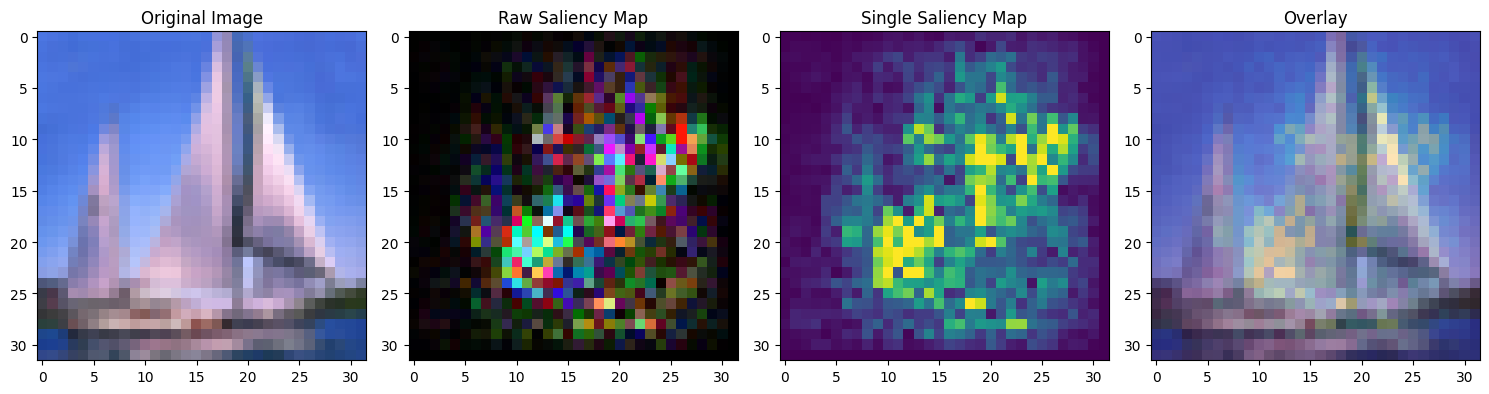

Image label: Ship
Model prediction: Ship


In [ ]:
# Select a correctly labeled image
i = 454

# 1123 car

# Get image, label and prediction
right_image = test_images_tensor[i,]
right_image_label = labels_names[test_labels_tensor[i]]
right_image_pred = labels_names[test_predictions_tensor[i]]

# Get saliency map
saliency_map = get_saliency_map(CNN, right_image)

# Plot saliency map
plot_saliency_map(saliency_map, right_image, right_image_label, right_image_pred)

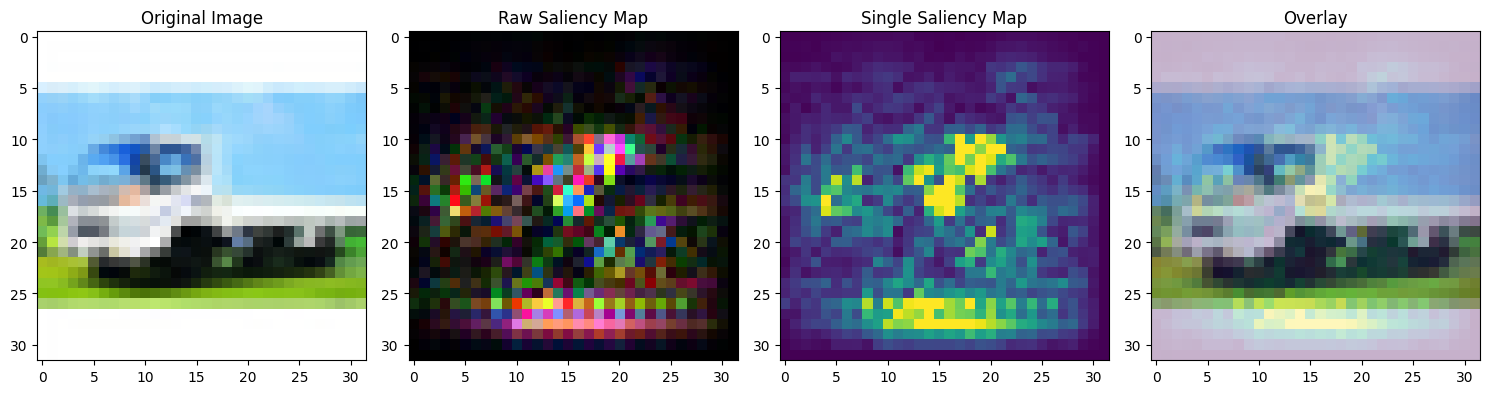

Image label: Truck
Model prediction: Airplane


In [ ]:
# Select an incorrectly labeled image

i = 72

# 4013
# Get image, label and prediction
wrong_image = test_images_tensor[i,]
wrong_image_label = labels_names[test_labels_tensor[i]]
wrong_image_pred = labels_names[test_predictions_tensor[i]]

# Get saliency map
saliency_map = get_saliency_map(CNN, wrong_image)

# Plot saliency map
plot_saliency_map(saliency_map, wrong_image, wrong_image_label, wrong_image_pred)

**Interpretation**

We've observed two examples of vanilla saliency maps, one for a correctly labeled image and another for an incorrectly labeled image.

They offer pretty intepretable results:

- in the first image, which is correctly predicted, the neural network seems to correctly focus on the ship, particularly on its sails;

- in the second one the model seems to focus on the background rather then the truck, which could explain why it predicts the image as an airplane.

### Exercise 3: Advanced saliency maps (1 point)

> For this exercise, you can read [2] for an overview on the limits of vanilla saliency maps and a description of SmoothGrad.

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.

🟩 **Completion requirement**: Implement the SmoothGrad procedure for the same point. Has the explanation improved? Bonus points if you can avoid running a for-loop, and by calling the gradient operation a single time.


**Answer**

I will provide three functions:
- `mean_saliency_map` receives as input a batched image tensor of shape (N,image_shape), computes N saliency maps, and return the mean of their absolute values;
- `smooth_grad_procedure` uses the function above to compute the SmoothGrad procedure;
- `plot_smooth_grad` which is just a custom function for plotting results.


`mean_saliency_map` will be also used in the exercise 4, since it is computationally optimized.

In [ ]:
# This function computes in parallel the saliency maps for each image in the images_tensor (Nximage_shape) and returns their mean.
# It will be used both here and in the following section.

def mean_saliency_map(model, images_tensor):

    # Get number of images
    N = images_tensor.shape[0]

    with tf.GradientTape() as tape:

      # Keep an eye on all the images
      tape.watch(images_tensor)

      # Predict them all
      result = model(images_tensor, training=False)
      preds = tf.reduce_max(result, axis = 1)

      # N x image_shape Saliency maps
      saliency_maps = tape.gradient(preds, images_tensor)

    # Take the absolute value of the mean with respect to N
    mean_saliency_map = tf.reduce_mean(tf.abs(saliency_maps), axis=0)

    return mean_saliency_map


# To apply the previous function we need to create from a single image a N x image_shape tensor.
# We will add to each image copy a different noise, always coming from a centered normal.

def smooth_grad_procedure(model, input_image, N, sd):

  # Get final tensor shape (Nx32x32x3 in our case)
  input_shape = input_image.shape.as_list()
  input_shape.insert(0, N)
  final_shape = tf.TensorShape(input_shape)

  # Add batch dimension to the input image for broadcasting
  batched_input_image = tf.expand_dims(input_image, axis = 0)

  # Get a 4D tensor of N randomized images
  random_images = batched_input_image + tf.random.normal(shape = final_shape, mean = 0, stddev= sd)

  # Apply mean_saliency_map function
  smooth_grad_saliency_map = mean_saliency_map(model, random_images)

  return smooth_grad_saliency_map


# Computes and plots the SmoothGrad results. N is fixed at 50 as suggested in [2].
# From [2] is also the idea of plotting the various percentages of noise level.
def plot_smooth_grad(model, input_image, N = 50, noise_levels = np.array([0, 10, 20, 30, 40, 50])):

  # Handle the case of 1x32x32x3 input image shape
  input_image = tf.reshape(input_image, (32, 32, 3))

  # Obtain standard deviations
  min = tf.reduce_min(input_image)
  max = tf.reduce_max(input_image)
  standard_deviations = noise_levels / 100  * (max - min)

  fig, axes = plt.subplots(2, len(standard_deviations) + 1, figsize=(21, 7))

  # Plot the original image
  ax = axes[0,0]
  ax.set_title(f"Original Image")
  ax.imshow(input_image)
  ax = axes[1,0]
  ax.imshow(input_image)

  for i in range(len(standard_deviations)):

    smooth_grad = smooth_grad_procedure(model, input_image, N, standard_deviations[i])
    smooth_grad = plot_saliency_preprocessing(smooth_grad)

    flat_smooth_grad = tf.reduce_max(smooth_grad,2)

    # Plot smooth_grad
    ax = axes[0, i + 1]
    ax.set_title(f"Noise level: {noise_levels[i]}%")
    ax.imshow(smooth_grad)

    # Plot flat_smooth_grad
    ax = axes[1, i + 1]
    ax.imshow(flat_smooth_grad)
  plt.tight_layout()
  plt.show()



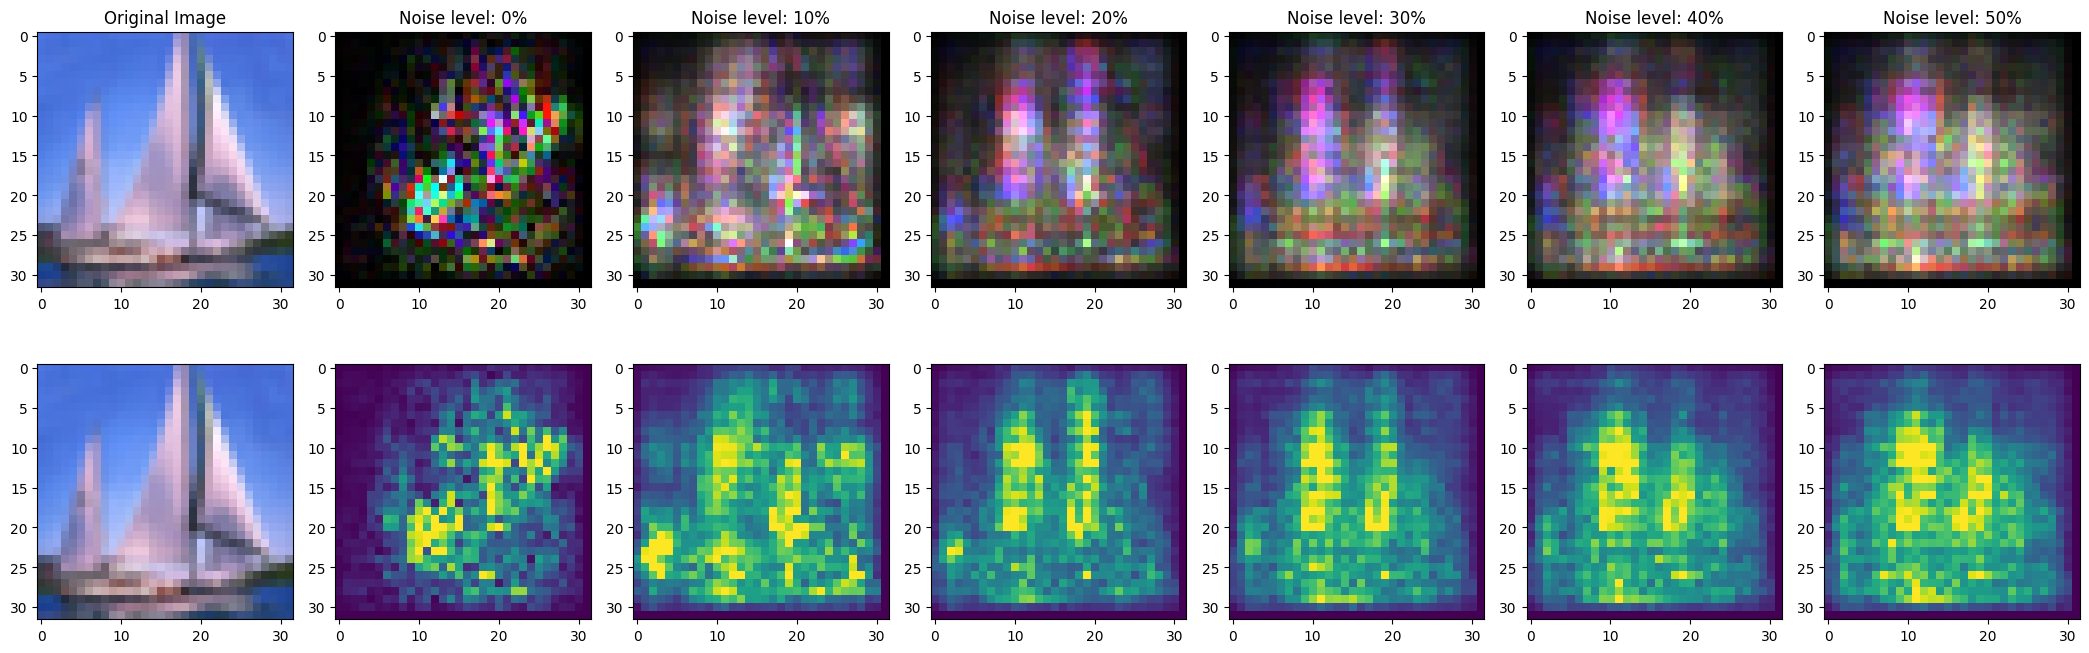

In [ ]:
# Smooth grad on the correctly labeled image
plot_smooth_grad(CNN, right_image)

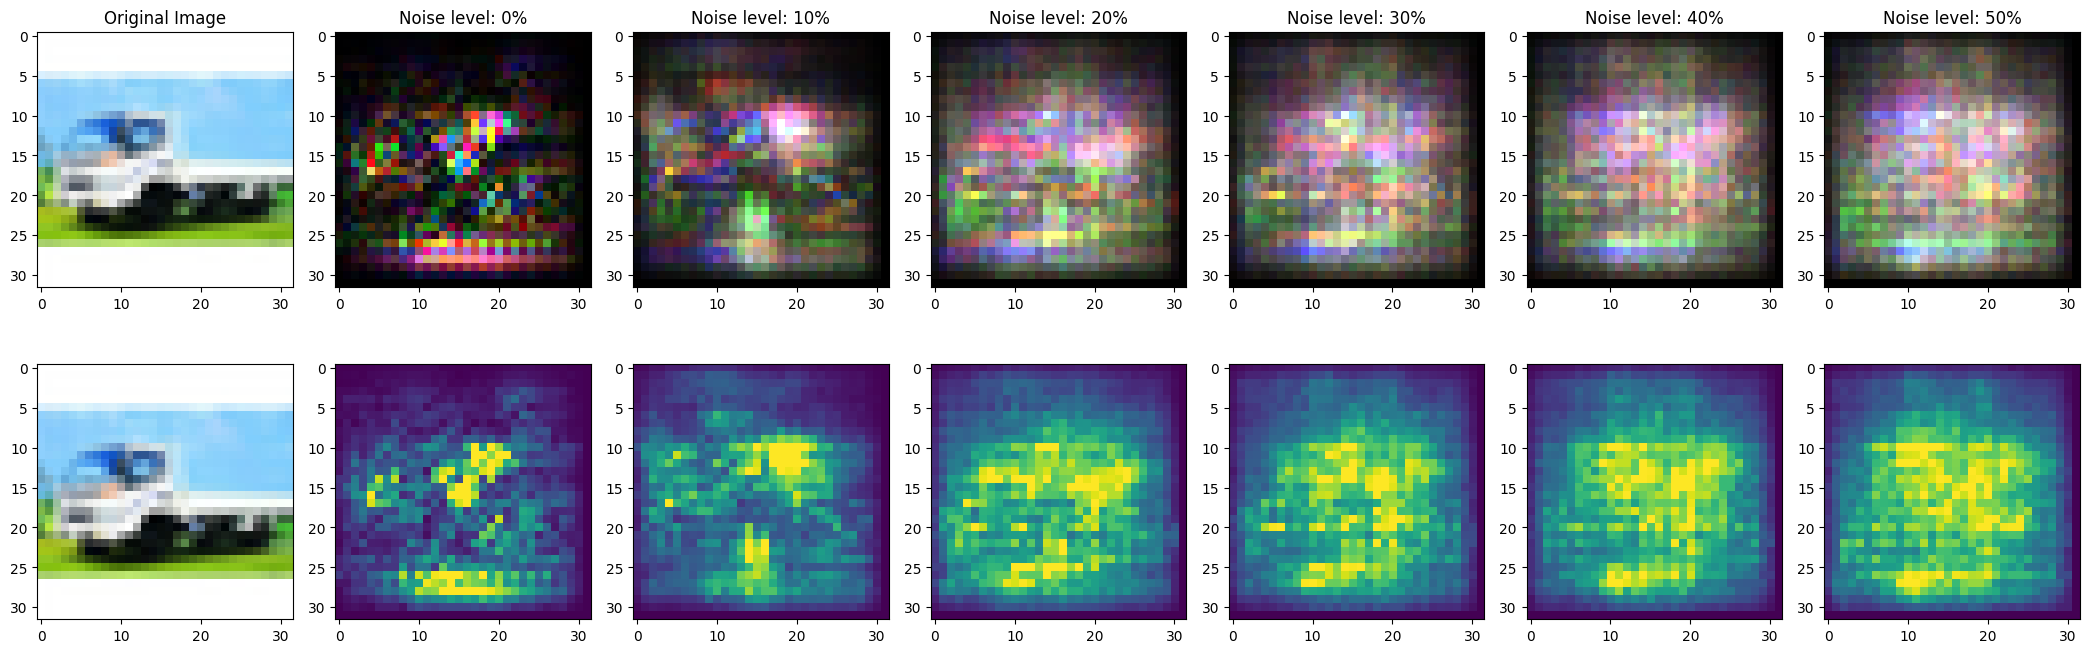

In [ ]:
# Smooth gradient on the incorrectly labeled image
plot_smooth_grad(CNN, wrong_image)

**Interpretation**

As pointed out in the paper we get the most intepretable results with a $10$% / $20$% noise level.

The SmoothGrad procedure seems to confirm the previous results :

- the SmoothGrad saliency map in the first image is much sharper, it clearly indicates the neural network is giving importance to the sails of the ship;
- in the second image this procedure again confirms that the model is foucusing on everything but the truck.

These results, which improve the vanilla saliency maps, can explain the behaviour on the correct / incorrect labeling of the images.

### Exercise 4: Global explanations (2 points)

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.

**Exercise 4.1**: write a function to compute in parallel the saliency for multiple examples. Note that the resulting matrix $S$ will have shape $(n, d)$, where $n$ is the number of examples and $d$ the size of the input, which is the Jacobian of the network. Try to write the function by avoiding for-loops and multiple tapes, using the [proper tools from TensorFlow](https://www.tensorflow.org/guide/advanced_autodiff).

**Answer**

In [ ]:
# Reintroducing the function for clarity, as it was defined earlier in the code:

def mean_saliency_map(model, images_tensor):

    # Get number of images
    N = images_tensor.shape[0]

    with tf.GradientTape() as tape:

      # Keep an eye on all the images
      tape.watch(images_tensor)

      # Predict them all
      result = model(images_tensor, training=False)
      preds = tf.reduce_max(result, axis = 1)

      # N x image_shape Saliency maps
      saliency_maps = tape.gradient(preds, images_tensor)

    # Take the absolute value of the mean with respect to N
    mean_saliency_map = tf.reduce_mean(tf.abs(saliency_maps), axis=0)

    return mean_saliency_map

:**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

**Answer**

We can start by applying the function above on the whole test set:

In [ ]:
# Get global saliency map on the whole test set
test_global_saliency = mean_saliency_map(CNN, test_images_tensor)

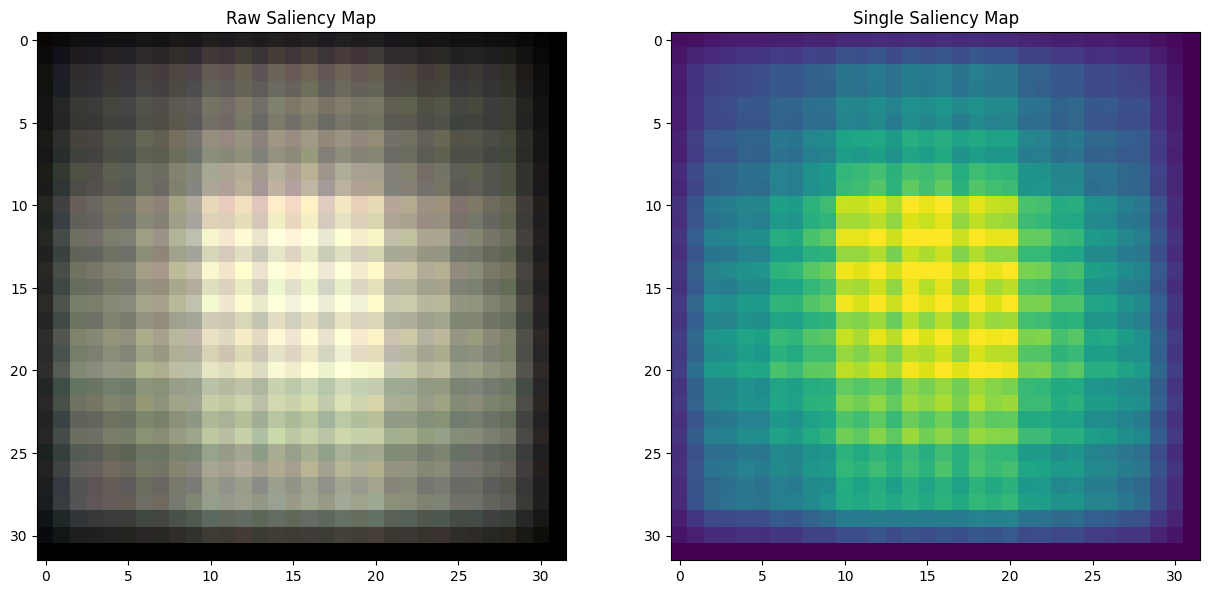

In [ ]:
# Plot it
plot_saliency_map(test_global_saliency)

**Comments**

Well, there is not much to be said.

The only possible interpretation of this saliency map is that the model, on average, gives importance to pixel in the center of the image, which is totally reasonable.

A next reasonable step is to apply this tool to correctly predicted images within the same class.

We could hope that that in this subset, we may uncover a more "global" interpretation:


In [ ]:
# Get correctly labeled images/labels in test
correctly_labeled_indexes = test_predictions_tensor == test_labels_tensor
correct_images = test_images_tensor[correctly_labeled_indexes]
correct_labels = test_labels_tensor[correctly_labeled_indexes]

In [ ]:
# Iterating over classes,  append a global saliency map for each class
CNN_classes_saliency_maps = []
for i in range(10):
  class_i = correct_images[correct_labels == i]
  class_i_saliency_map = mean_saliency_map(CNN, class_i)
  CNN_classes_saliency_maps.append(class_i_saliency_map)

# Get single saliency maps
CNN_classes_flat_saliency_maps = [tf.reduce_max(class_saliency_map, axis = 2) for class_saliency_map in CNN_classes_saliency_maps]

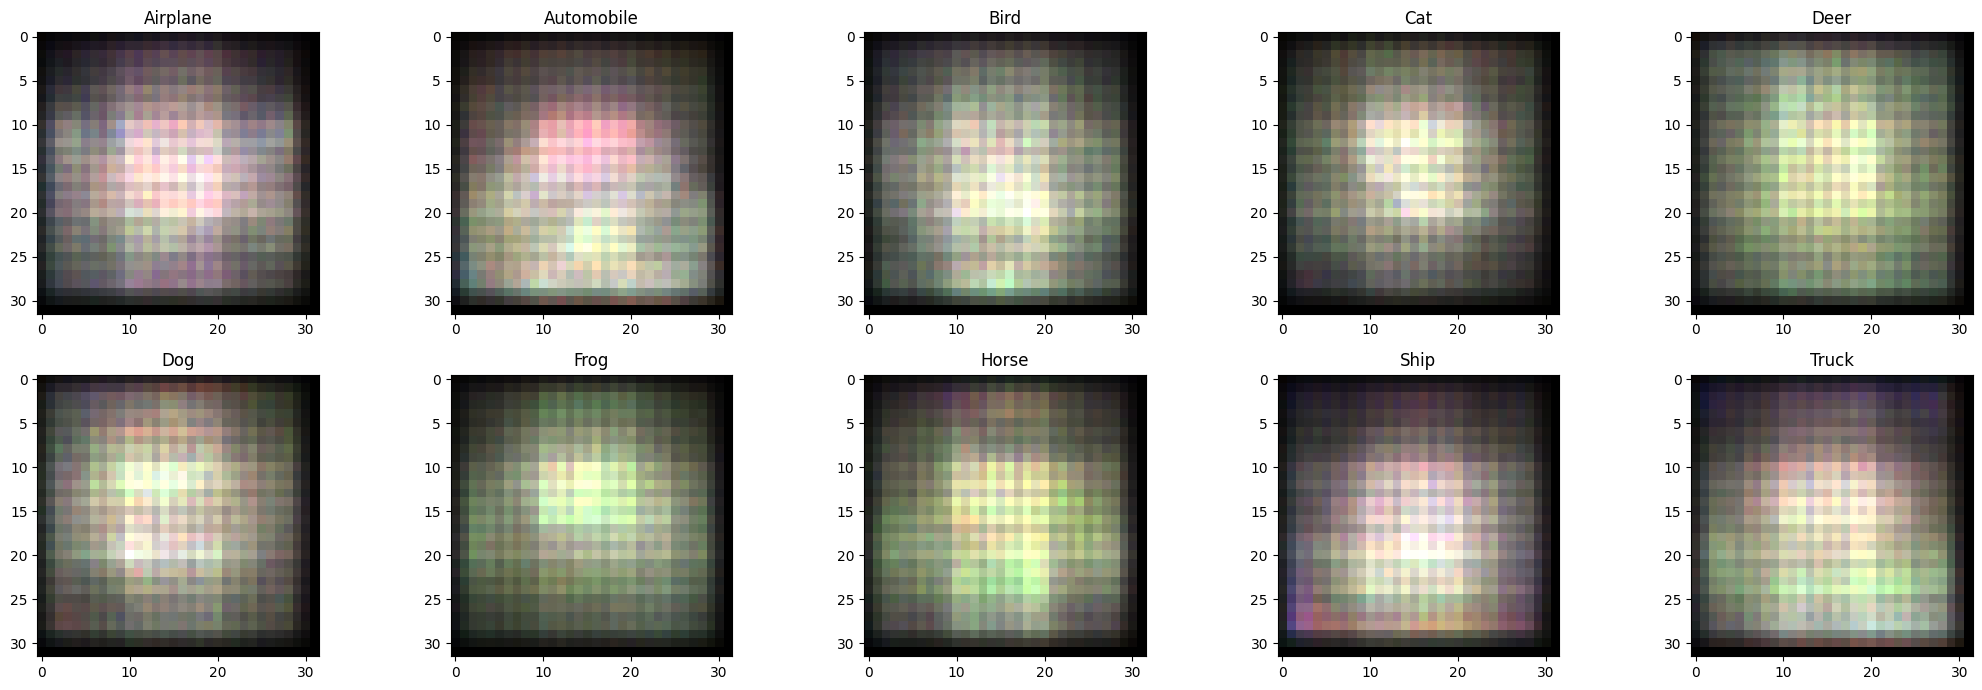

In [ ]:
# Plot each class saliency map
plot_images(CNN_classes_saliency_maps, labels_names, 2, 5, plot_saliency_preprocessing)

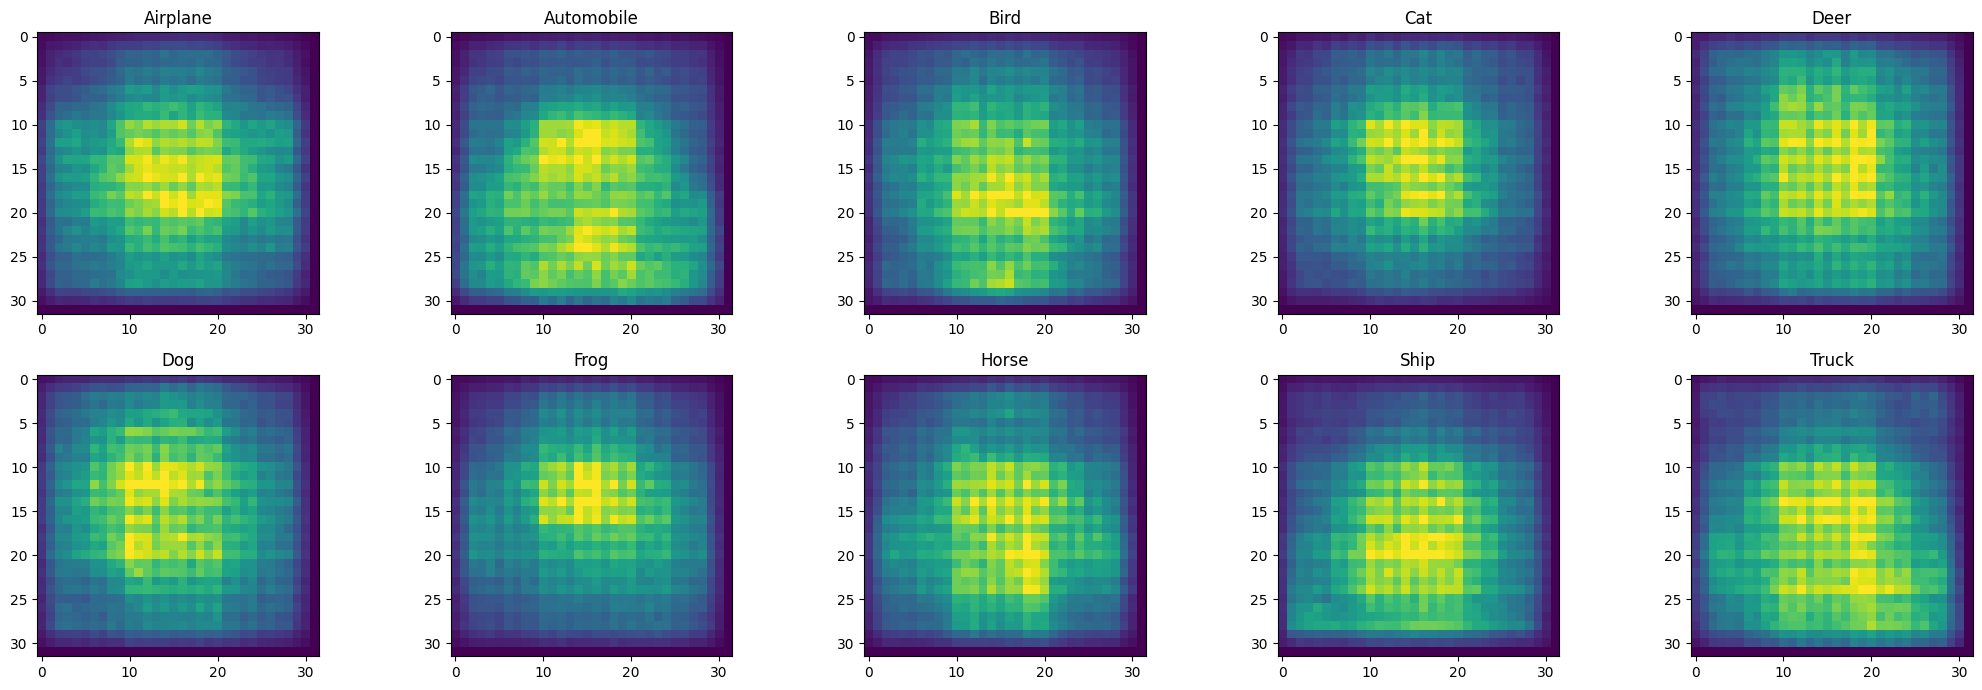

In [ ]:
# Plot each class saliency map
plot_images(CNN_classes_flat_saliency_maps, labels_names, 2, 5, plot_saliency_preprocessing)

**Comments**

Our hopes have been completely shattered.

Even here there is no trace of a possible global intepretation.

**Exercise 4.3**: note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

**Answer**

I don't expect this method to really shine since it will probably behave poorly on this classification task.

Anyway, we will achieve this by creating another neural network composed by only three layers:
- normalization;
- flattening;
- dense linear layer;

In [ ]:
# Model Hyperparameters

# High number of epochs
num_epochs = 100

# Optimizer setup
lr = 0.000005
my_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = lr)

In [ ]:
# Define our toy neural network
Linear_reg = Sequential()

# Normalization layer

Linear_reg.add(Normalization())

# Flatten the 3D image to 1D for the fully connected layer

# 32x32x3
Linear_reg.add(Flatten())
# 3072

# Dense Linear Layer

# 3072
Linear_reg.add(Dense(units = 10, input_dim = 3072, activation = "relu")) # 1x100
# 10

In [ ]:
# LinearNN building and summary
Linear_reg.build(input_shape=(None, 32, 32, 3))
Linear_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 32, 32, 3)         7         
 tion)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                30730     
                                                                 
Total params: 30737 (120.07 KB)
Trainable params: 30730 (120.04 KB)
Non-trainable params: 7 (32.00 Byte)
_________________________________________________________________


In [ ]:
# Here we compile the CNN: we choose the SparseCategoricalCrossentropy as loss function and the accuracy as metrics.
# Here we set up a modelcheckpoint that stores the best model on the validation loss.
# This is beacause we will not run TracIn here

# Compile the CNN
Linear_reg.compile(optimizer = my_optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Save the best model on validation (its already set up to save your best weights in case you want to retrain Linear_reg)
model_checkpoint_callback = ModelCheckpoint(
    filepath ='train_weights/your_best_weights_Linear_reg.h5',
    save_weights_only = True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)

**Run the following two cells only if you want to retrain the model**

In [ ]:
# Train Linear_reg
Linear_reg_history = Linear_reg.fit(
    x = train_preprocessed,
    epochs = num_epochs,
    validation_data = val_preprocessed,
    batch_size = n_batch,
    callbacks= model_checkpoint_callback)

# Save history
Linear_reg_history = Linear_reg_history.history

# Load your best model weights
Linear_reg.load_weights('models_weights/your_best_weights_Linear_reg.h5')

**Run this cell if you want to load my training/model**

In [ ]:
# Load training history
with open('train_histories/Linear_reg_history.json', 'r') as fp:
    Linear_reg_history = json.load(fp)

# Load my best model weights
Linear_reg.load_weights('models_weights/my_best_weights_Linear_reg.h5')

**Accuracy and loss plots**

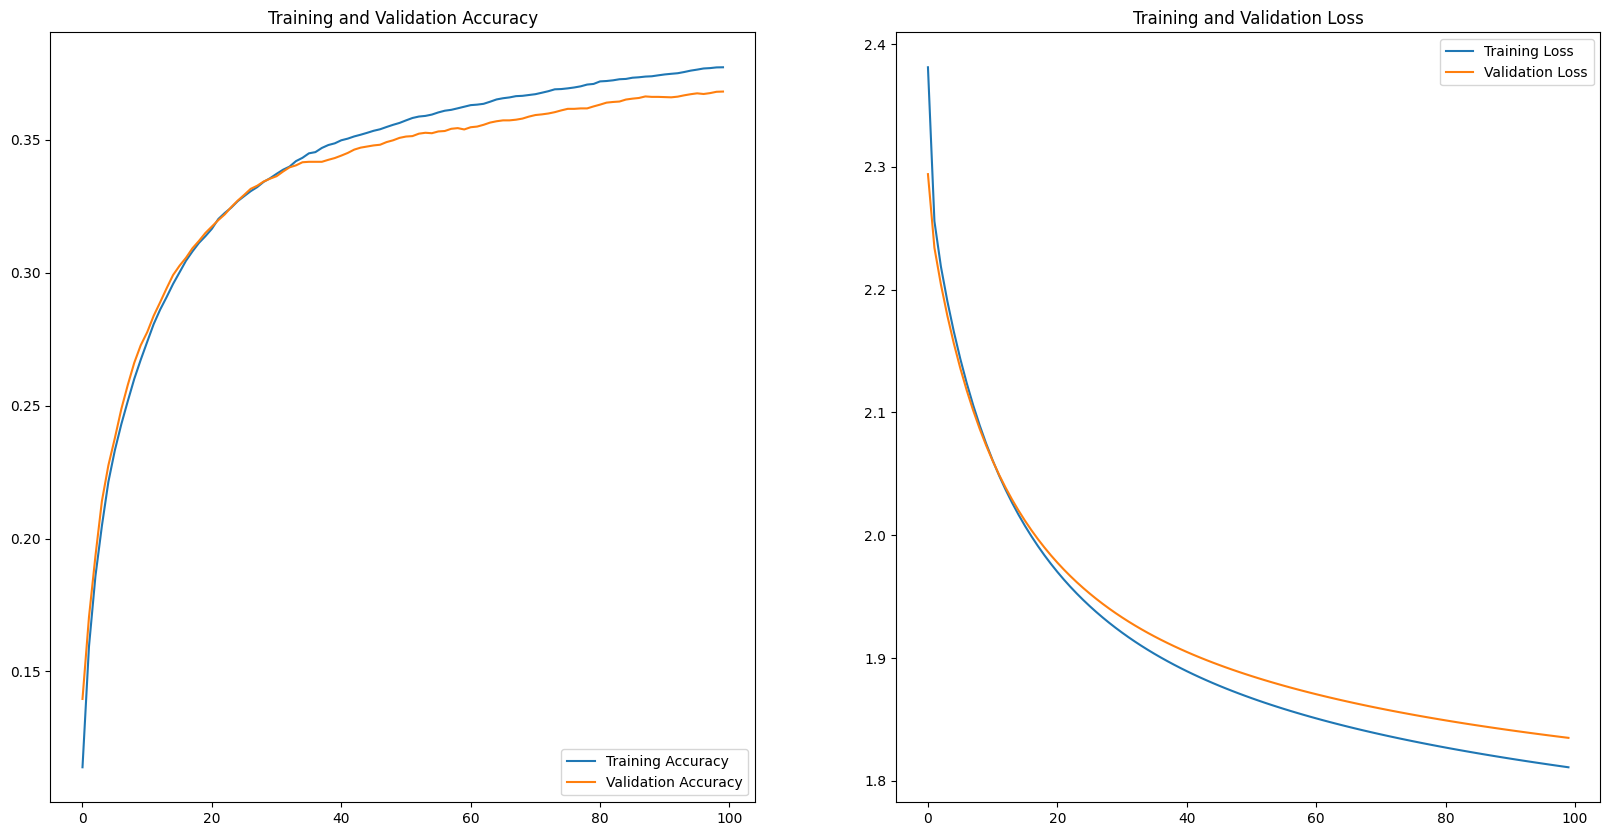

In [ ]:
# Store accuracies
acc = Linear_reg_history['accuracy']
val_acc = Linear_reg_history['val_accuracy']
# Store losses
loss = Linear_reg_history['loss']
val_loss = Linear_reg_history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Plot accuracies
ax = axes[0]
ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

# Plot losses
ax = axes[1]
ax.plot( loss, label='Training Loss')
ax.plot( val_loss, label='Validation Loss')
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on test
test_loss, test_accuracy = Linear_reg.evaluate(test_preprocessed)

30/30 [==============================] - 1s 7ms/step - loss: 1.7997 - accuracy: 0.3875


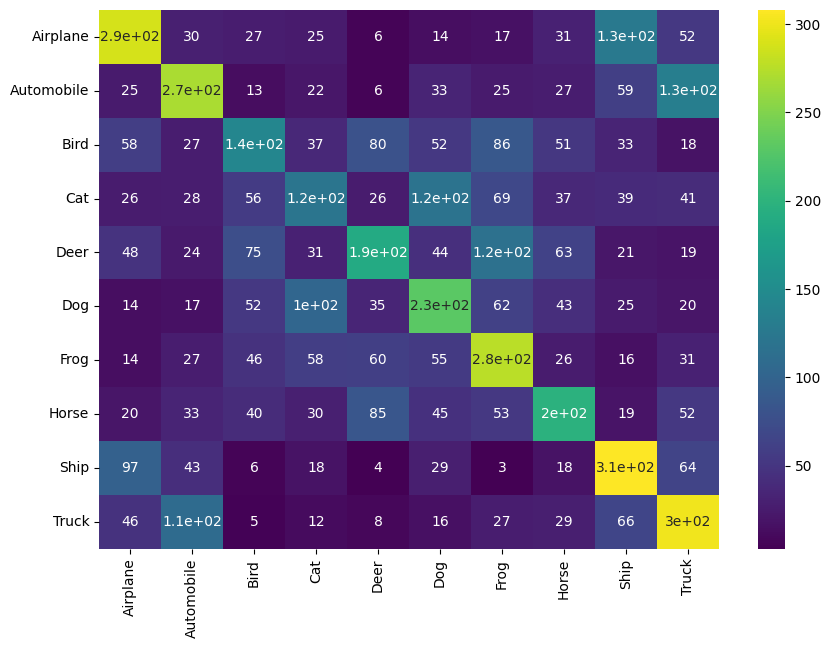

In [ ]:
# Create confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels = test_labels_tensor, predictions = tf.argmax(Linear_reg(test_images_tensor),1))

# Plot confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(pd.DataFrame(confusion_matrix, index = labels_names, columns = labels_names), annot = True, cmap = "viridis")
plt.show()

**Linear_reg Saliency maps**

In this simpler model  given two images belonging to the same predicted class their saliency map will be the same.

In general **to each predicted class corresponds a single saliency map**.

Hence, without having to choose a specific input image, we can directly plot them:

In [ ]:
# Extract weights into the right shape
linear_regression_weights = Linear_reg.get_weights()[3]
linear_regression_weights_reshaped = tf.reshape(linear_regression_weights, (32,32,3,10))
linear_regression_weights_permuted = tf.transpose(linear_regression_weights_reshaped, perm=[3, 0, 1, 2])

# Get classes saliency maps
classes_saliency_maps = tf.abs(linear_regression_weights_permuted)
classes_flat_saliency_maps = [tf.reduce_max(class_saliency_map, axis = 2) for class_saliency_map in classes_saliency_maps]

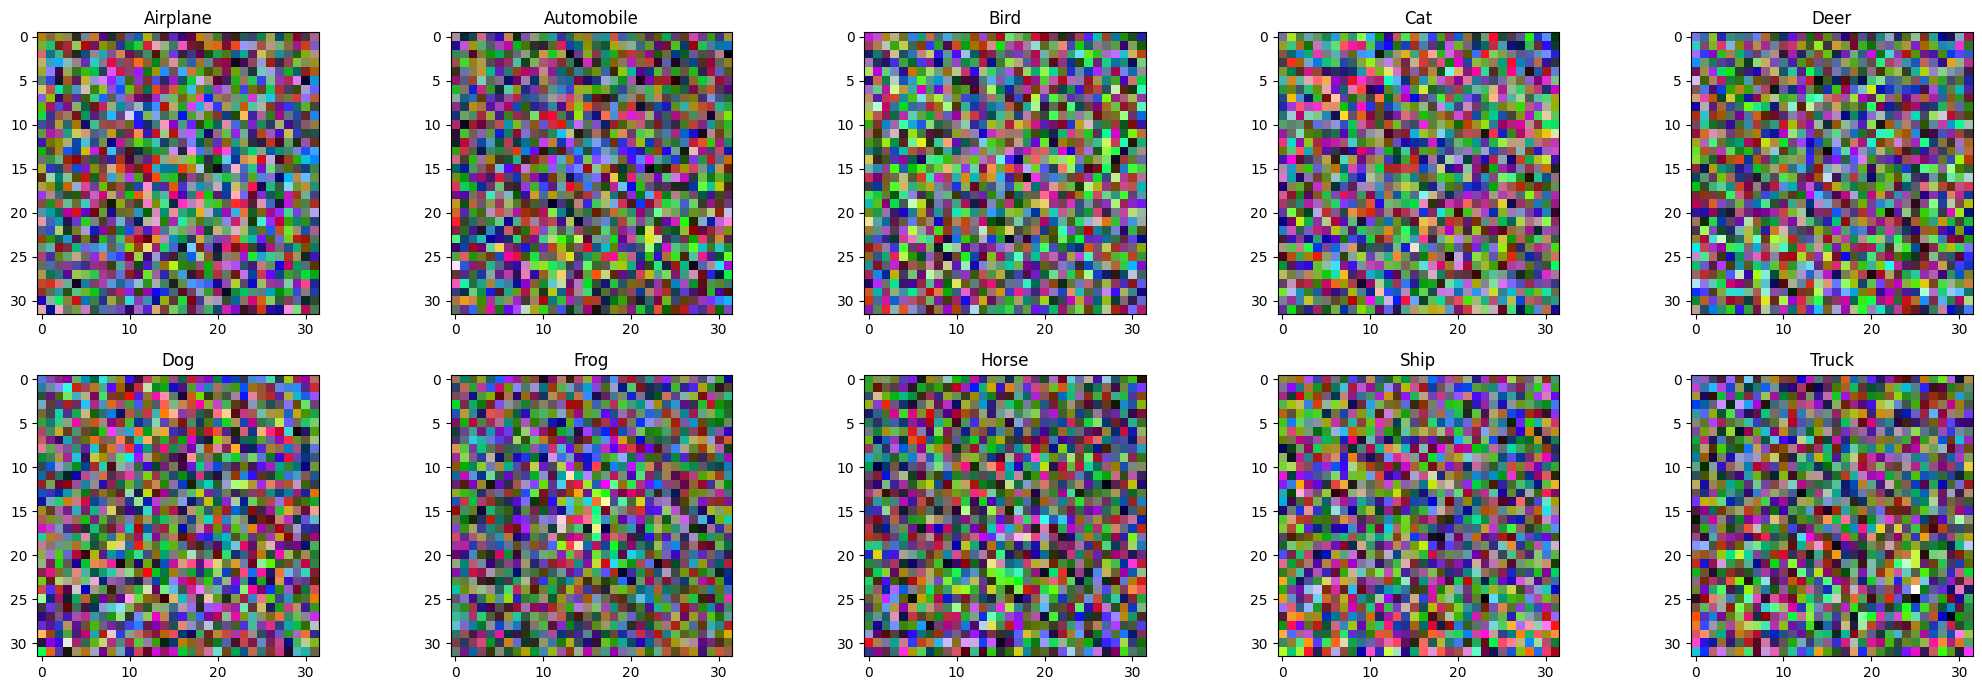

In [ ]:
# Plot each class saliency map
plot_images(classes_saliency_maps, labels_names, 2, 5, plot_saliency_preprocessing)

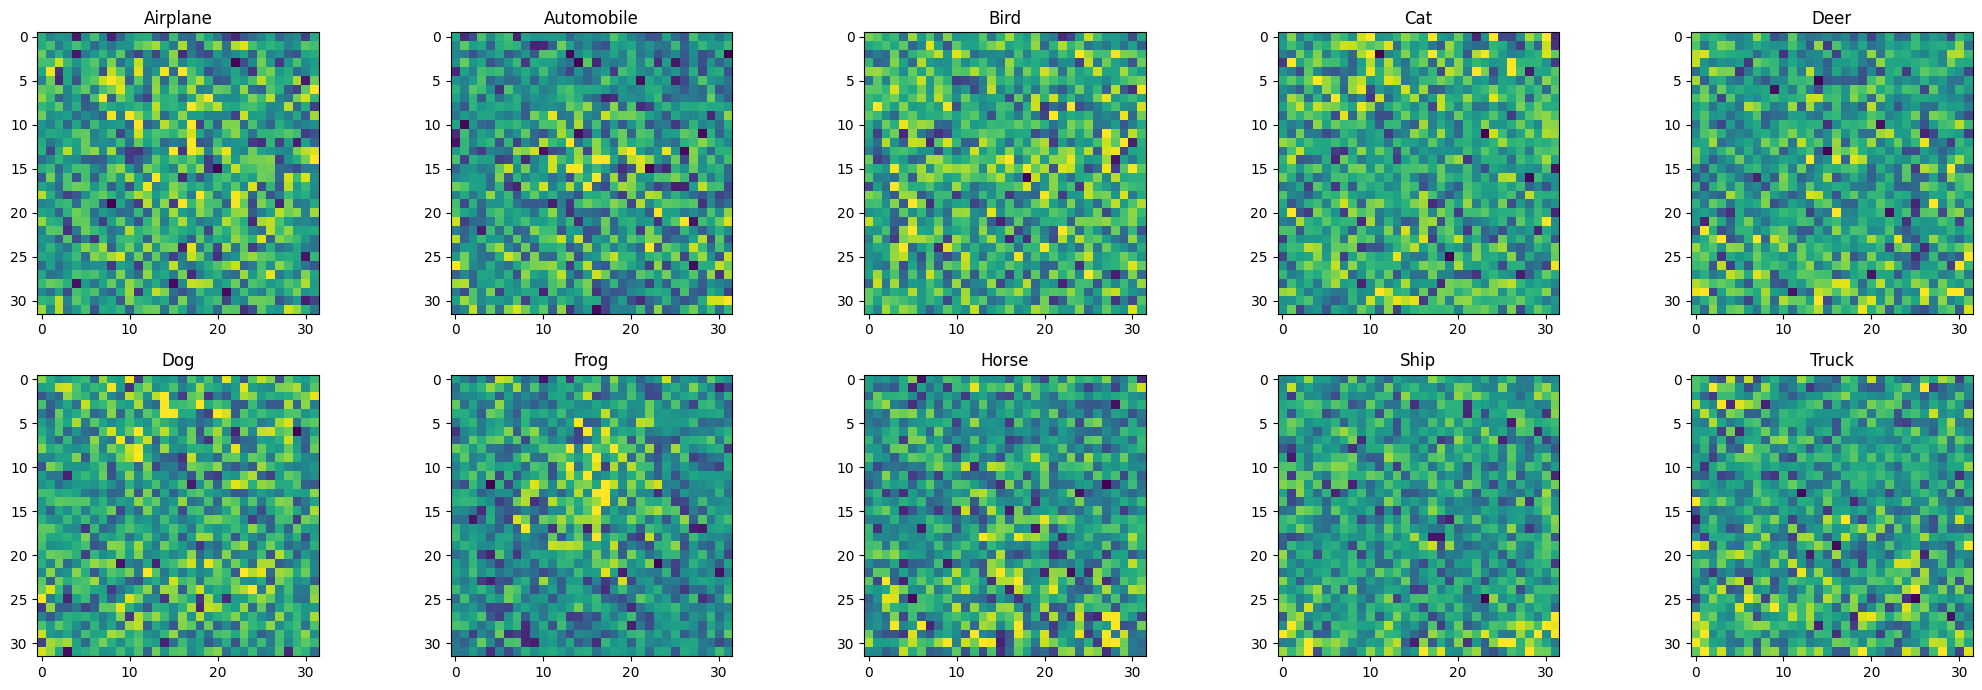

In [ ]:
# Plot each class single saliency map
plot_images(classes_flat_saliency_maps, labels_names, 2, 5, plot_saliency_preprocessing)

**Intperpretation**

As expected the results are pretty uninterpretable.

With a lot of fantasy we could see some aggregation of pixels, for example in the frog class, but in general each class saliency map could be confused for random noise.

### Optional exercises and parting words

> ⚠ Explainability is a complex topic, with multiple issues arising from the over-abundance of techniques, their instability, etc. While an interesting research topic to pursue, never use blindly these techniques in high-stake applications!

These exercises were just a brief and short introduction to the topic of explainability. Below you can find some additional exercises to tackle if you are interested. Remember that these are not part of your grade, but I am happy to provide feedback if they are of interest to you.

1. There are dozens of possible variations on feature attribution methods, which may or may not provide better results (see [4] for a benchmarking and this nice [Distill blog post](https://distill.pub/2020/attribution-baselines/)). **[Integrated Gradients](https://arxiv.org/abs/1703.01365)** are an interesting example, where the saliency is integrated over a path ranging from an empty input to the true input. Try implementing integrated gradients.
2. **Data attribution** methods are a different class of explanation methods, which try to predict what points in the dataset where most influential to a given prediction (e.g., a picture of a cat will be especially influential on similar pictures). One example of such methods is TracIn [5], which stores checkpoints of the model during training and evaluates the correlation of the gradients. Try to implement TracIn or any other metric of data influence.
3. A recent line of research tries to use large language models (e.g., ChatGPT) to explain other models (e.g., see [Language models can explain neurons in language models](https://openai.com/research/language-models-can-explain-neurons-in-language-models)). If you have access to an LLM, you can try it! Take a specific neuron in the model, and collect the activation for multiple examples. Provide these activations to the LLM, and prompt it to provide a human-understandable explanation. What is the result?

### Integrated gradients ##

To implement the integrated gradients procedure I mainly referred to the provided source and from https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=it.


The Integrated Gradients method calculates the contribution of each feature to the model's prediction for a given input $x$. The formula is defined as:

$ IntegratedGrads_i(x) = (x- x') \times \int_{\alpha=0}^1 \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x} d\alpha $

Where:
- $x$ is the input,
- $x'$ is the baseline,
- $F$ is the model's prediction function,
- $\frac{\partial F(x' + \alpha \times (x - x'))}{\partial x}$ is the partial derivative of the model's prediction at the point $x' + \alpha \times (x - x')$,
- The integral is a numerical approximation over a path from the baseline $x'$ to the actual input $x$.



In our case to pratically compute the Integrated Gradient for a given `input_image`, we will follow these steps:

- **Set Baseline Image:**
   Set an "information empty" image as the baseline.

- **Choose Number of Steps:**
   Select the number `n_steps` to divide the interval [0, 1] for approximating the integral.

- **Generate Interpolated Images:**
   Create a batch of `interpolated_images` using `alphas` to linearly scale from the baseline to the `input_image`.

- **Compute Mean Gradient:**
   Compute the mean gradient for this batch.

- **Calculate Integrated Gradient:**
   Multiply the mean saliency map by the difference between the `input_image` and the baseline.

We will use the following functions:
- `mean_gradient` a version of `mean_saliency_map` that doesn't apply `tf.abs`;
- `interpolated_images` which will generate the Interpolated Images;
- `IntegratedGrads` which will do the whole process in  a single function.

It's important to note that selecting the "correct" baseline is crucial for this method, since the importance of pixels aligned with the baseline will be  set to zero (we are multiplying the mean gradient for
`input_image - baseline`).

After those considerations I will show Integrated Gradients results with three different baselines:
- black baseline;
- white baseline;
- noise baseline.

In [ ]:
# Returns the mean of the gradients given a tensor of inputs
def mean_gradient(model, images_tensor):

    # Get number of images
    N = images_tensor.shape[0]

    with tf.GradientTape() as tape:

      # Keep an eye on all the images
      tape.watch(images_tensor)

      # Predict them all
      result = model(images_tensor, training=False)
      preds = tf.reduce_max(result, axis = 1)

      # N x image_shape gradients
      gradients = tape.gradient(preds, images_tensor)

    # Take the absolute value of the mean with respect to N
    mean_gradient = tf.reduce_mean(gradients, axis=0)

    return mean_gradient



# Returns the "images path" between the baseline and the input image
# as a 4D tensor of shape: (n_steps, image_shape)
def interpolate_images(baseline, input_image, alphas):

  # Get alphas, baseline and input_image into the right shape for broadcasting
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(input_image, axis=0)

  # Compute distance intperpolated images
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images


# Computes the Integrated Gradients procedure
def IntegratedGrads(model, input_image, baseline, n_steps = 100):

  # Get alphas
  alphas = tf.linspace(start = 0.0, stop = 1.0, num = n_steps)

  # Get interpolated images
  interpolated_images = interpolate_images(baseline, input_image, alphas)

  # Get mean gradient
  mean_grad = mean_gradient(model, interpolated_images)

  # Compute integrated gradients
  integrated_grads = (input_image - baseline) * mean_grad

  return integrated_grads

**Black baseline**

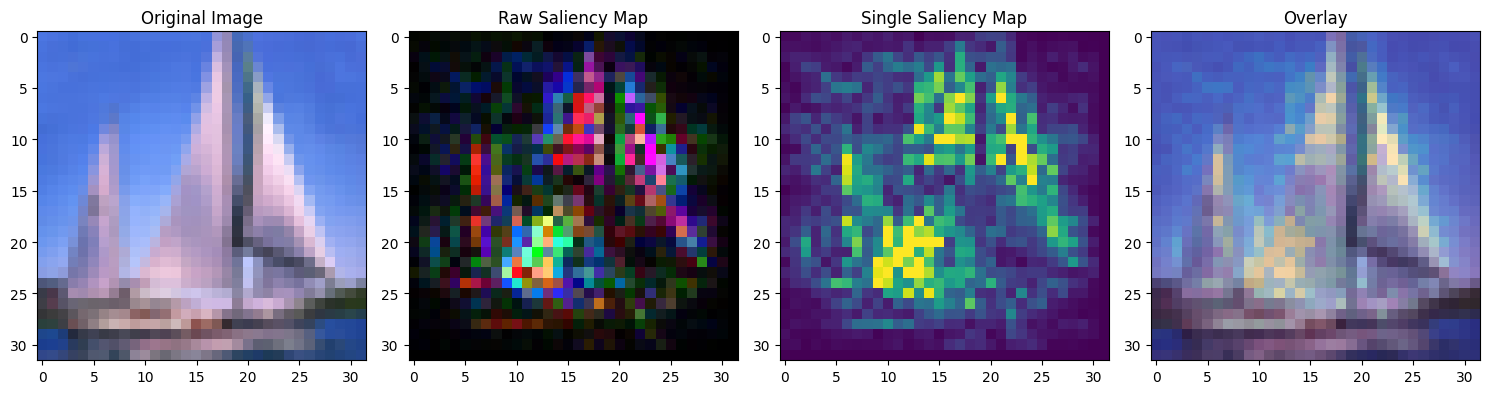

In [ ]:
# We set a black baseline.
black_baseline = tf.zeros(shape=(32,32,3))

# Set n_steps
n_steps = 100

# Compute integrated grad
integrated_grad = IntegratedGrads(CNN, right_image ,black_baseline, n_steps)

# For plotting, as done before, we take the absolute value
integrated_grad = tf.abs(integrated_grad)

# Plot it
plot_saliency_map(integrated_grad, right_image)

**White baseline**

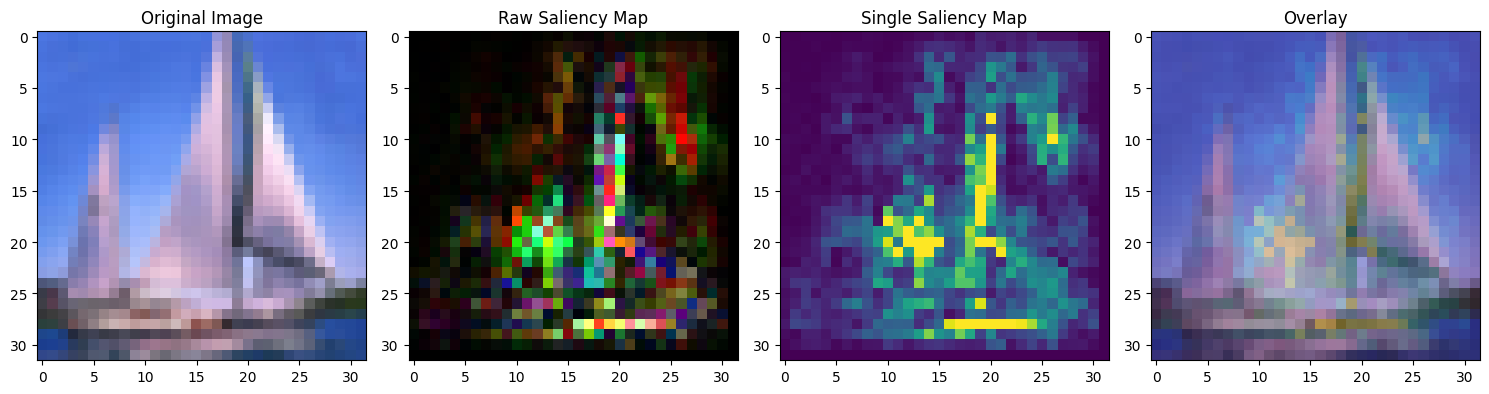

In [ ]:
# We set a white baseline.
white_baseline = tf.ones(shape=(32,32,3))

# Set n_steps
n_steps = 100

# Compute integrated grad
integrated_grad = IntegratedGrads(CNN, right_image ,white_baseline, n_steps)

# For plotting, as done before, we take the absolute value
integrated_grad = tf.abs(integrated_grad)

# Plot it
plot_saliency_map(integrated_grad, right_image)

**Noise baseline**

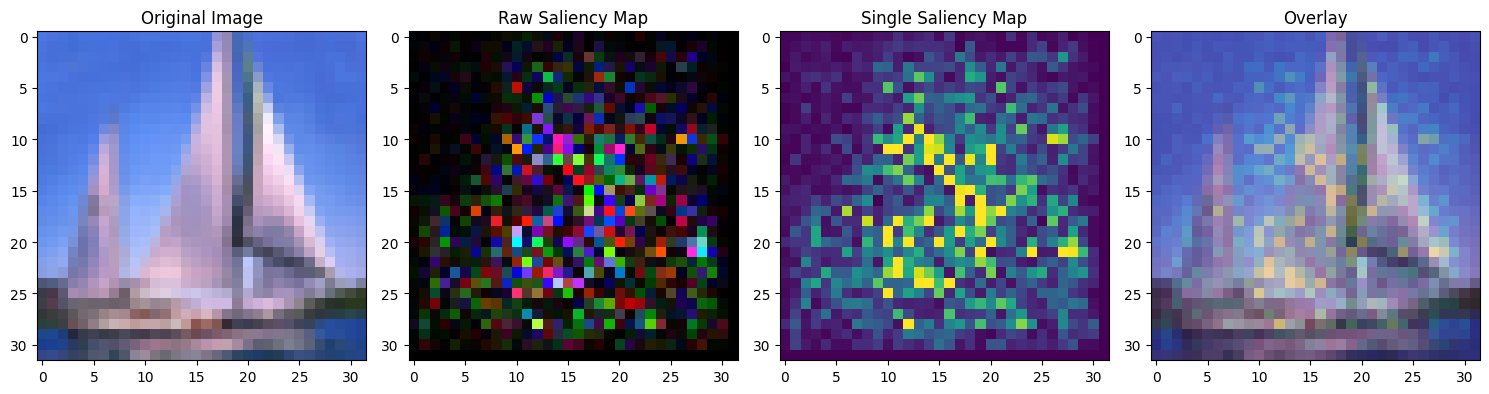

In [ ]:
# We set a noise baseline.
noise_baseline = tf.random.uniform(shape=(32,32,3))

# Set n_steps
n_steps = 100

# Compute integrated grad
integrated_grad = IntegratedGrads(CNN, right_image ,noise_baseline, n_steps)

# For plotting, as done before, we take the absolute value
integrated_grad = tf.abs(integrated_grad)

# Plot it
plot_saliency_map(integrated_grad, right_image)

**Comments**

At first glance, integrated gradients seems a highly promising technique.

As said in the beginning the choice of the correct baseline is crucial, infact in images its not trivial to determine which image can represent at best the concept of empty.

Since white, black or any color induces intrinsically a bias in our procedure, I believe the best choice is the noise_baseline, which, sadly, is also the one that produces the less intepretable results.

It's funny to observe that when we are doing integrated gradients with a noise baseline we are apllying a kind of generalized version of the SmoothGrad procedure.

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 10/11/2023 23:59** on the Google Classrom page.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.